# 文本挖掘
# homework4

In [1]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining and the weather is sweet'])
bag = count.fit_transform(docs)

In [2]:
' '.join(dir(count)) 

'__class__ __delattr__ __dict__ __doc__ __format__ __getattribute__ __hash__ __init__ __module__ __new__ __reduce__ __reduce_ex__ __repr__ __setattr__ __sizeof__ __str__ __subclasshook__ __weakref__ _char_ngrams _char_wb_ngrams _check_vocabulary _count_vocab _get_param_names _limit_features _sort_features _validate_vocabulary _white_spaces _word_ngrams analyzer binary build_analyzer build_preprocessor build_tokenizer decode decode_error dtype encoding fit fit_transform fixed_vocabulary fixed_vocabulary_ get_feature_names get_params get_stop_words input inverse_transform lowercase max_df max_features min_df ngram_range preprocessor set_params stop_words stop_words_ strip_accents token_pattern tokenizer transform vocabulary vocabulary_'

In [3]:
count.get_feature_names()

[u'and', u'is', u'shining', u'sun', u'sweet', u'the', u'weather']

In [4]:
print(count.vocabulary_)

{u'and': 0, u'weather': 6, u'sweet': 4, u'sun': 3, u'is': 1, u'the': 5, u'shining': 2}


In [5]:
type(bag)

scipy.sparse.csr.csr_matrix

In [6]:
print(bag.toarray())

[[0 1 1 1 0 1 0]
 [0 1 0 0 1 1 1]
 [1 2 1 1 1 2 1]]


In [7]:
import pandas as pd    #使用pandas做表格
pd.DataFrame(bag.toarray(), columns = count.get_feature_names())

,and,is,shining,sun,sweet,the,weather
0,0,1,1,1,0,1,0
1,0,1,0,0,1,1,1
2,1,2,1,1,1,2,1


In [8]:
np.set_printoptions(precision=2)

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)   #l2 归一化处理，smooth平滑处理
print(tfidf.fit_transform(count.fit_transform(docs)).toarray())

[[ 0.    0.43  0.56  0.56  0.    0.43  0.  ]
 [ 0.    0.43  0.    0.    0.56  0.43  0.56]
 [ 0.4   0.48  0.31  0.31  0.31  0.48  0.31]]


In [10]:
bag = tfidf.fit_transform(count.fit_transform(docs))
pd.DataFrame(bag.toarray(), columns = count.get_feature_names())  

,and,is,shining,sun,sweet,the,weather
0,0.000000,0.433708,0.558478,0.558478,0.000000,0.433708,0.000000
1,0.000000,0.433708,0.000000,0.000000,0.558478,0.433708,0.558478
2,0.404748,0.478102,0.307822,0.307822,0.307822,0.478102,0.307822


In [11]:
# 一个词的tfidf值
tf_is = 2    #is 的frequency 是2次
n_docs = 3   #总文本3个
idf_is = np.log((n_docs+1) / (3+1))
tfidf_is = tf_is * (idf_is + 1)
print('tf-idf of term "is" = %.2f' % tfidf_is)

tf-idf of term "is" = 2.00


In [12]:
# 最后一个文本里的词的tfidf原始数值（未标准化）
tfidf = TfidfTransformer(use_idf=True, norm=None, smooth_idf=True)
raw_tfidf = tfidf.fit_transform(count.fit_transform(docs)).toarray()[-1]
raw_tfidf 

array([ 1.69,  2.  ,  1.29,  1.29,  1.29,  2.  ,  1.29])

In [13]:
# l2标准化后的tfidf数值
l2_tfidf = raw_tfidf / np.sqrt(np.sum(raw_tfidf**2))
l2_tfidf

array([ 0.4 ,  0.48,  0.31,  0.31,  0.31,  0.48,  0.31])

# 政府工作报告

### 0.读取数据

In [14]:
with open('D:/program/cjc2016/data/gov_reports1954-2016.txt', 'r') as f:
    reports = f.readlines()

In [15]:
len(reports)

47

In [16]:
print reports[32][:1000]

2002	2002年政府工作报告　　——2002年3月5日在第九届全国人民代表大会第五次会议上		　　　　　　　　　　　　　　　　　　 国务院总理朱镕基　  各位代表：　　现在，我代表国务院向大会作政府工作报告，请予审议，并请全国政协各位委员提出意见。　　首先报告２００１年的工作。　　新世纪第一年，全国各族人民在中国共产党领导下，面对复杂多变的国际形势，克服困难，阔步前进，改革开放和社会主义现代化建设取得了新的重大成就。　　国民经济保持良好发展势头。在世界经济增长明显减速的情况下，我们坚持扩大内需的方针，坚定地实施积极的财政政策和稳健的货币政策，实现了经济较快增长。２００１年国内生产总值达到９５９３３亿元，比上年增长７．３％。经济结构调整取得积极进展。农业结构有所优化，优质、专


In [17]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys 
import numpy as np
from collections import defaultdict
import statsmodels.api as sm
from wordcloud import WordCloud
import jieba
import matplotlib
import gensim
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
#matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei'] #指定默认字体 
matplotlib.rc("savefig", dpi=400)

### 1.分词

In [18]:
import jieba

seg_list = jieba.cut("今天天气不错", cut_all=True)
print("Full Mode: " + "/ ".join(seg_list))  # 全模式

seg_list = jieba.cut("今天天气不错", cut_all=False)
print("Default Mode: " + "/ ".join(seg_list))  # 精确模式

seg_list = jieba.cut("今天是晴天")  # 默认是精确模式
print(", ".join(seg_list))

seg_list = jieba.cut_for_search("今天是晴天，明天会下雨")  # 搜索引擎模式
print(", ".join(seg_list))

Building prefix dict from the default dictionary ...
Loading model from cache c:\users\admini~1\appdata\local\temp\jieba.cache
Loading model cost 0.668 seconds.
Prefix dict has been built succesfully.


Full Mode: 今天/ 今天天气/ 天天/ 天气/ 不错
Default Mode: 今天天气/ 不错
今天, 是, 晴天
今天, 是, 晴天, ，, 明天, 会, 下雨


### 2.停用词

In [19]:
filename ='D:/program/cjc2016/data/stopwords.txt'
stopwords = {}
f = open(filename, 'r')
line = f.readline().rstrip()
while line:
    stopwords.setdefault(line, 0)
    stopwords[line.decode('utf-8')] = 1
    line = f.readline().rstrip()
f.close()

In [20]:
adding_stopwords = [u'我们', u'要', u'地', u'有', u'这', u'人',
                    u'发展',u'建设',u'加强',u'继续',u'对',u'等',u'推进',u'工作',u'增加']
for s in adding_stopwords: stopwords[s]=10

### 3.关键词抽取

### 基于TF-IDF 算法的关键词抽取

In [21]:
import jieba.analyse
txt = reports[-1]
tf = jieba.analyse.extract_tags(txt, topK=200, withWeight=True)

In [22]:
print u"、".join([i[0] for i in tf[:50]])

发展、推进、改革、建设、创新、加快、经济、加强、促进、实施、政府、推动、完善、政策、全面、增长、社会、就业、企业、提高、创业、扩大、制度、坚持、一批、深化、人民、落实、支持、农村、试点、实现、安全、合作、工作、我国、动能、机制、加大、服务业、城镇、我们、服务、取得、依法、积极、中国、深入、结构性、民生


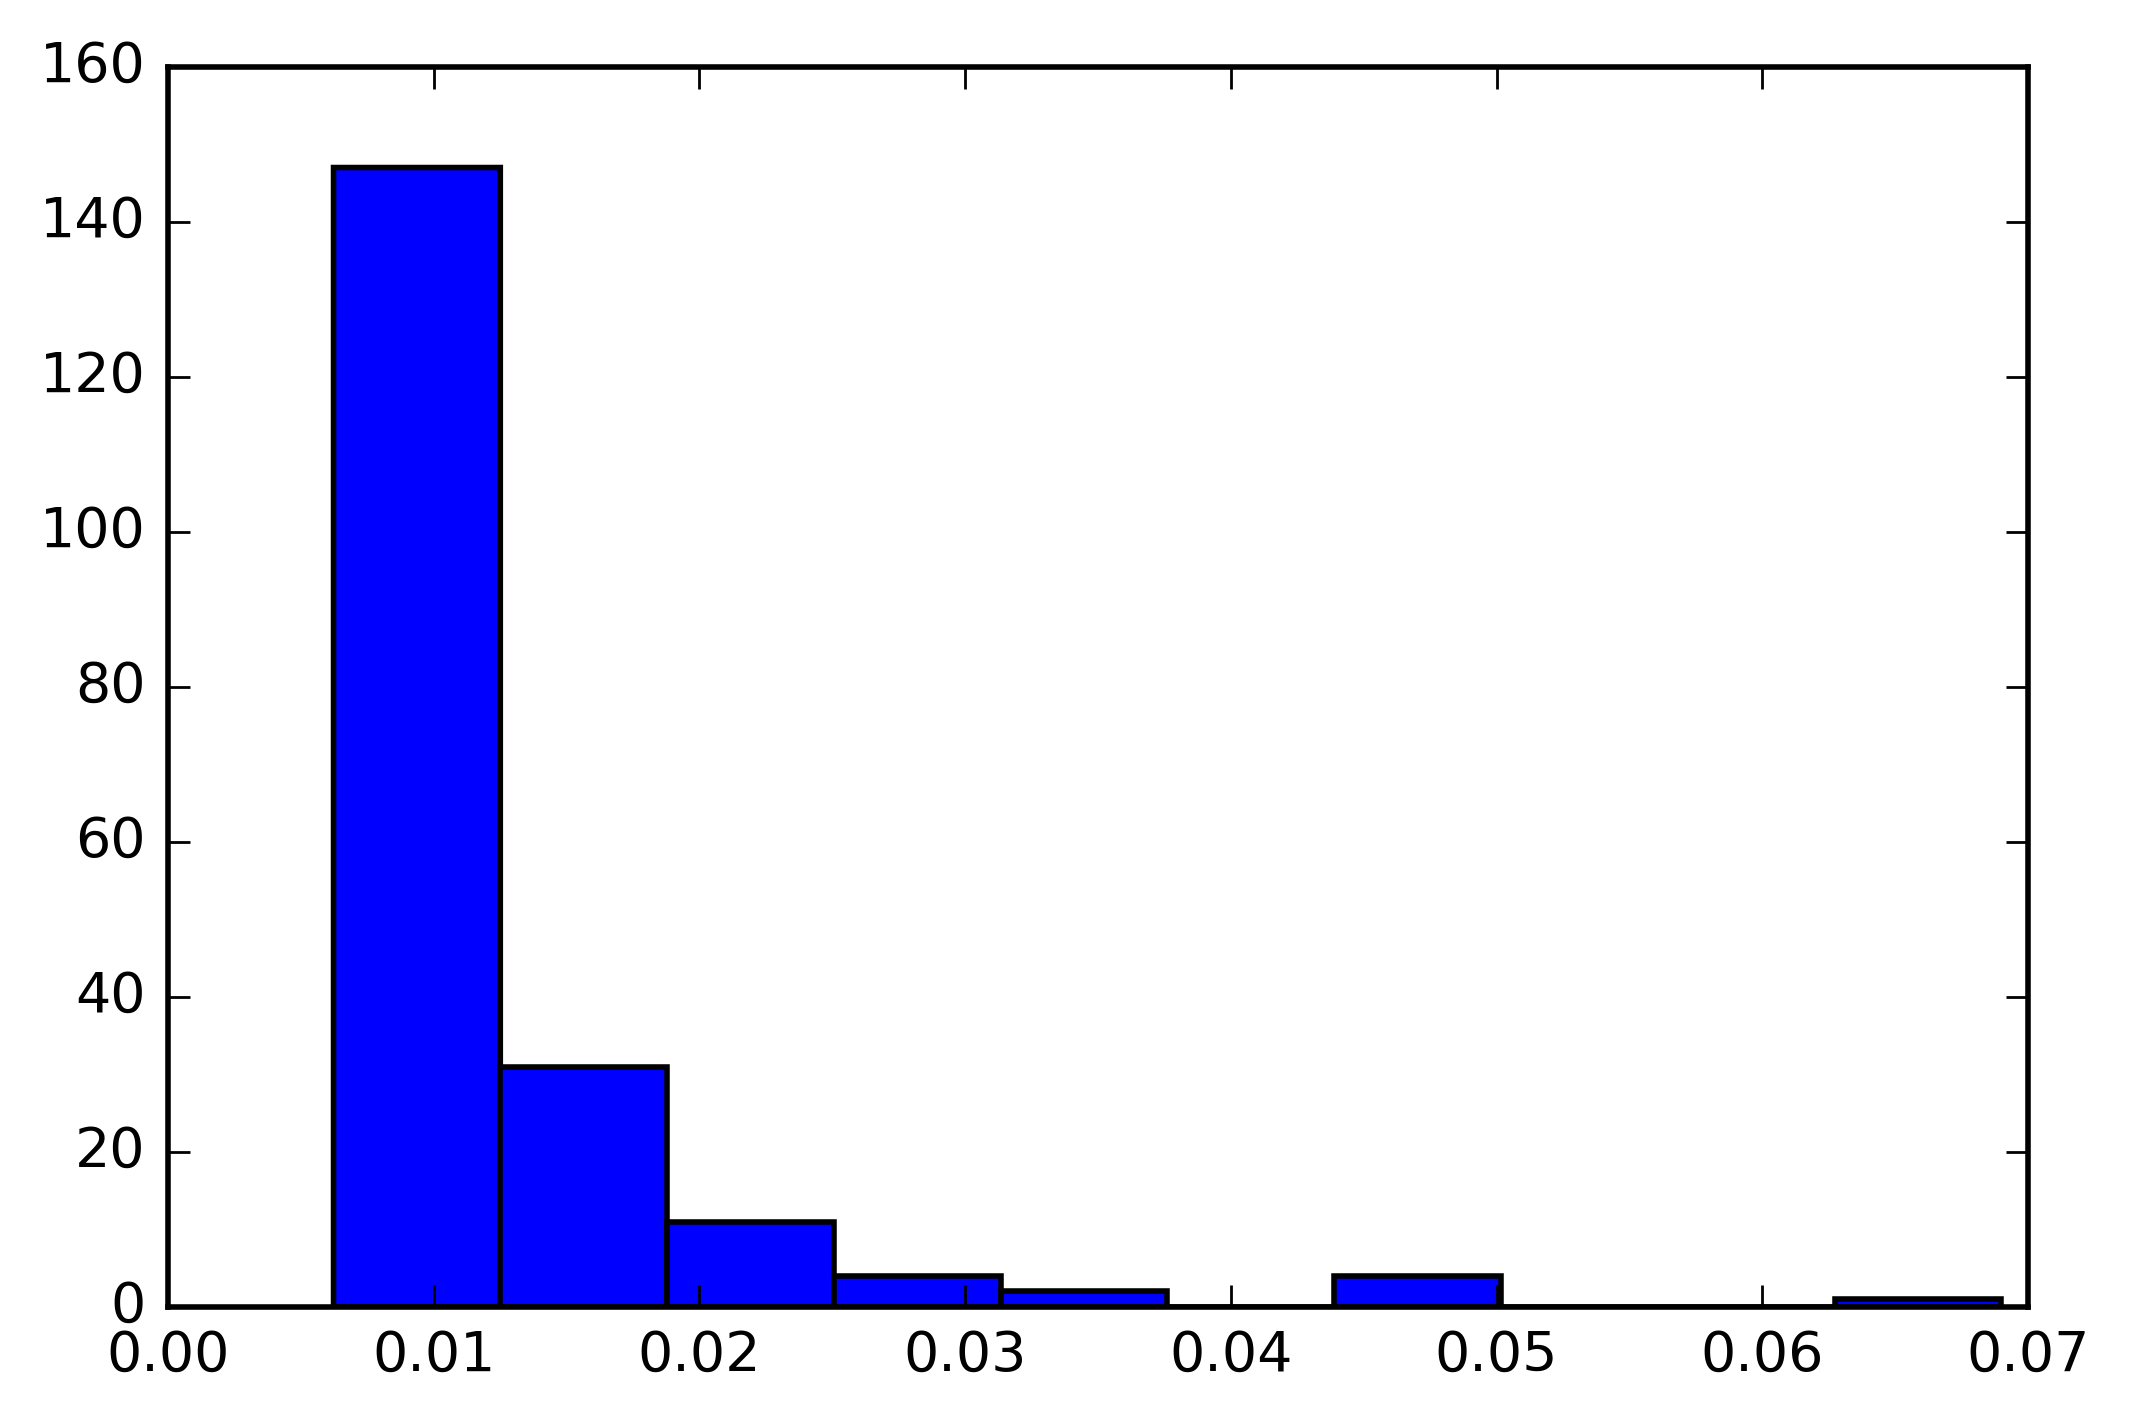

In [23]:
plt.hist([i[1] for i in tf])
plt.show()

### 基于 TextRank 算法的关键词抽取

In [24]:
tr = jieba.analyse.textrank(txt,topK=200, withWeight=True)
print u"、".join([i[0] for i in tr[:50]])

发展、建设、经济、改革、推进、创新、加强、加快、政府、推动、促进、实施、企业、政策、社会、制度、中国、提高、完善、全面、增长、扩大、支持、实现、工作、机制、人民、创业、服务、农村、试点、地方、坚持、国家、国际、继续、就业、合作、基本、加大、农业、投资、保护、问题、地区、依法、工程、取得、鼓励、建立


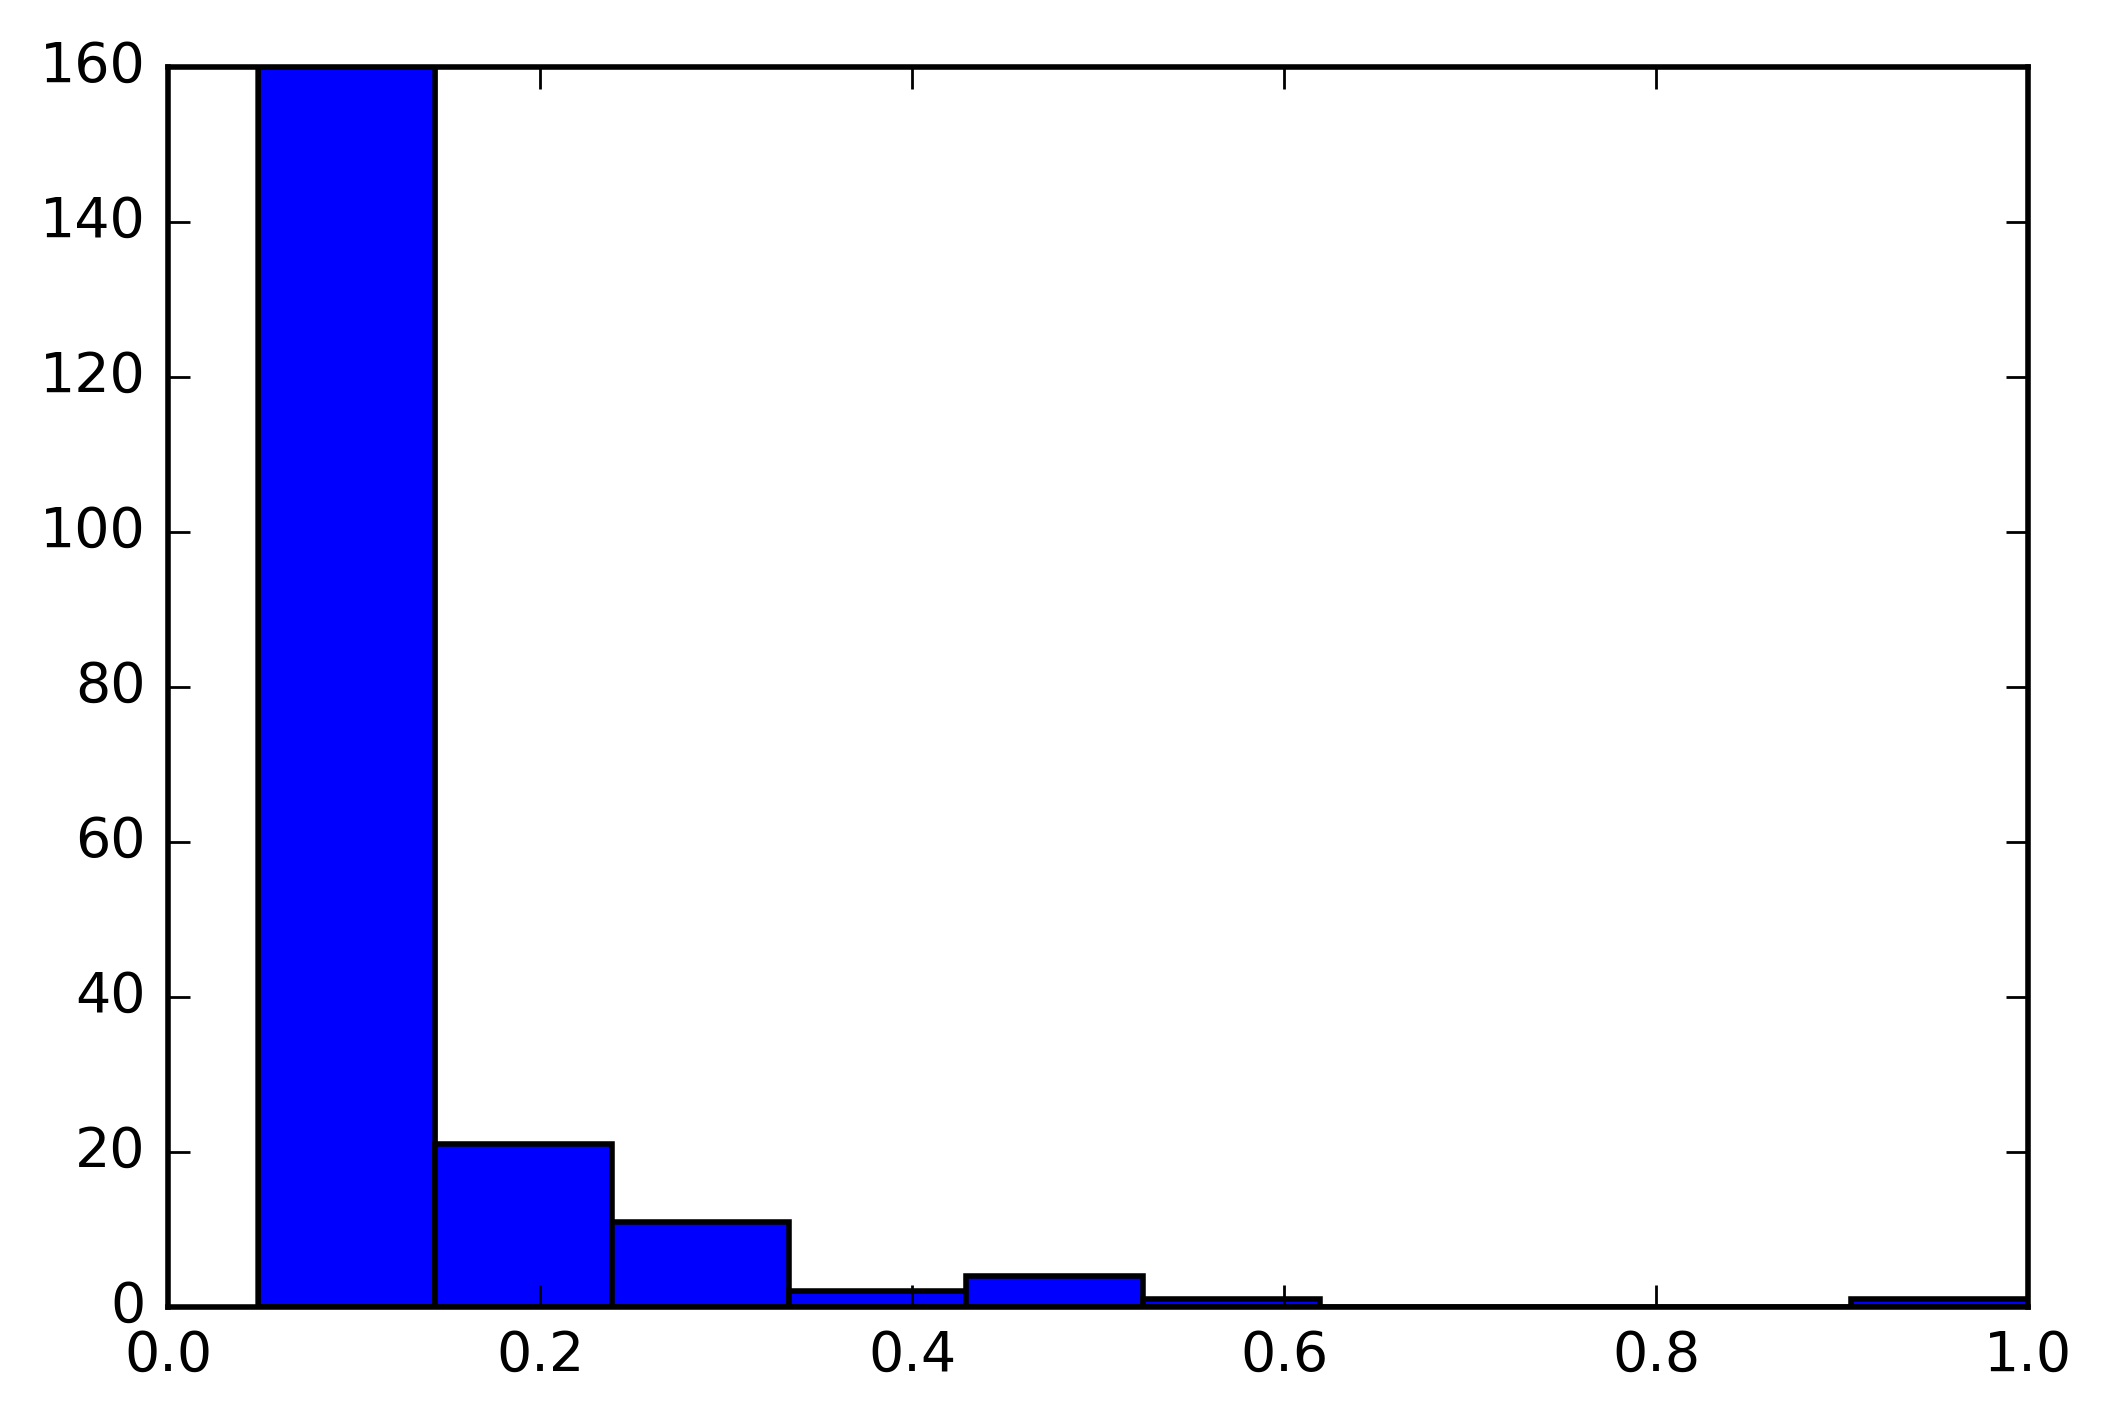

In [25]:
plt.hist([i[1] for i in tr])
plt.show()

In [26]:
import pandas as pd
import matplotlib
zhfont = matplotlib.font_manager.FontProperties(fname='C:/Windows/Fonts/msyh.ttc')


def keywords(index):
    txt = reports[-index]
    tf = jieba.analyse.extract_tags(txt, topK=200, withWeight=True)
    tr = jieba.analyse.textrank(txt,topK=200, withWeight=True)
    tfdata = pd.DataFrame(tf, columns=['word', 'tfidf'])
    trdata = pd.DataFrame(tr, columns=['word', 'textrank'])
    worddata = pd.merge(tfdata, trdata, on='word')
    plt.plot(worddata.tfidf, worddata.textrank, linestyle='',marker='.')
    for i in range(len(worddata.word)):
        plt.text(worddata.tfidf[i], worddata.textrank[i], worddata.word[i], fontproperties = zhfont,
                 fontsize = worddata.textrank[i]*15, color = 'red', rotation = 0)
    plt.title(txt[:4])
    plt.xlabel('Tf-Idf')
    plt.ylabel('TextRank')
    plt.show()

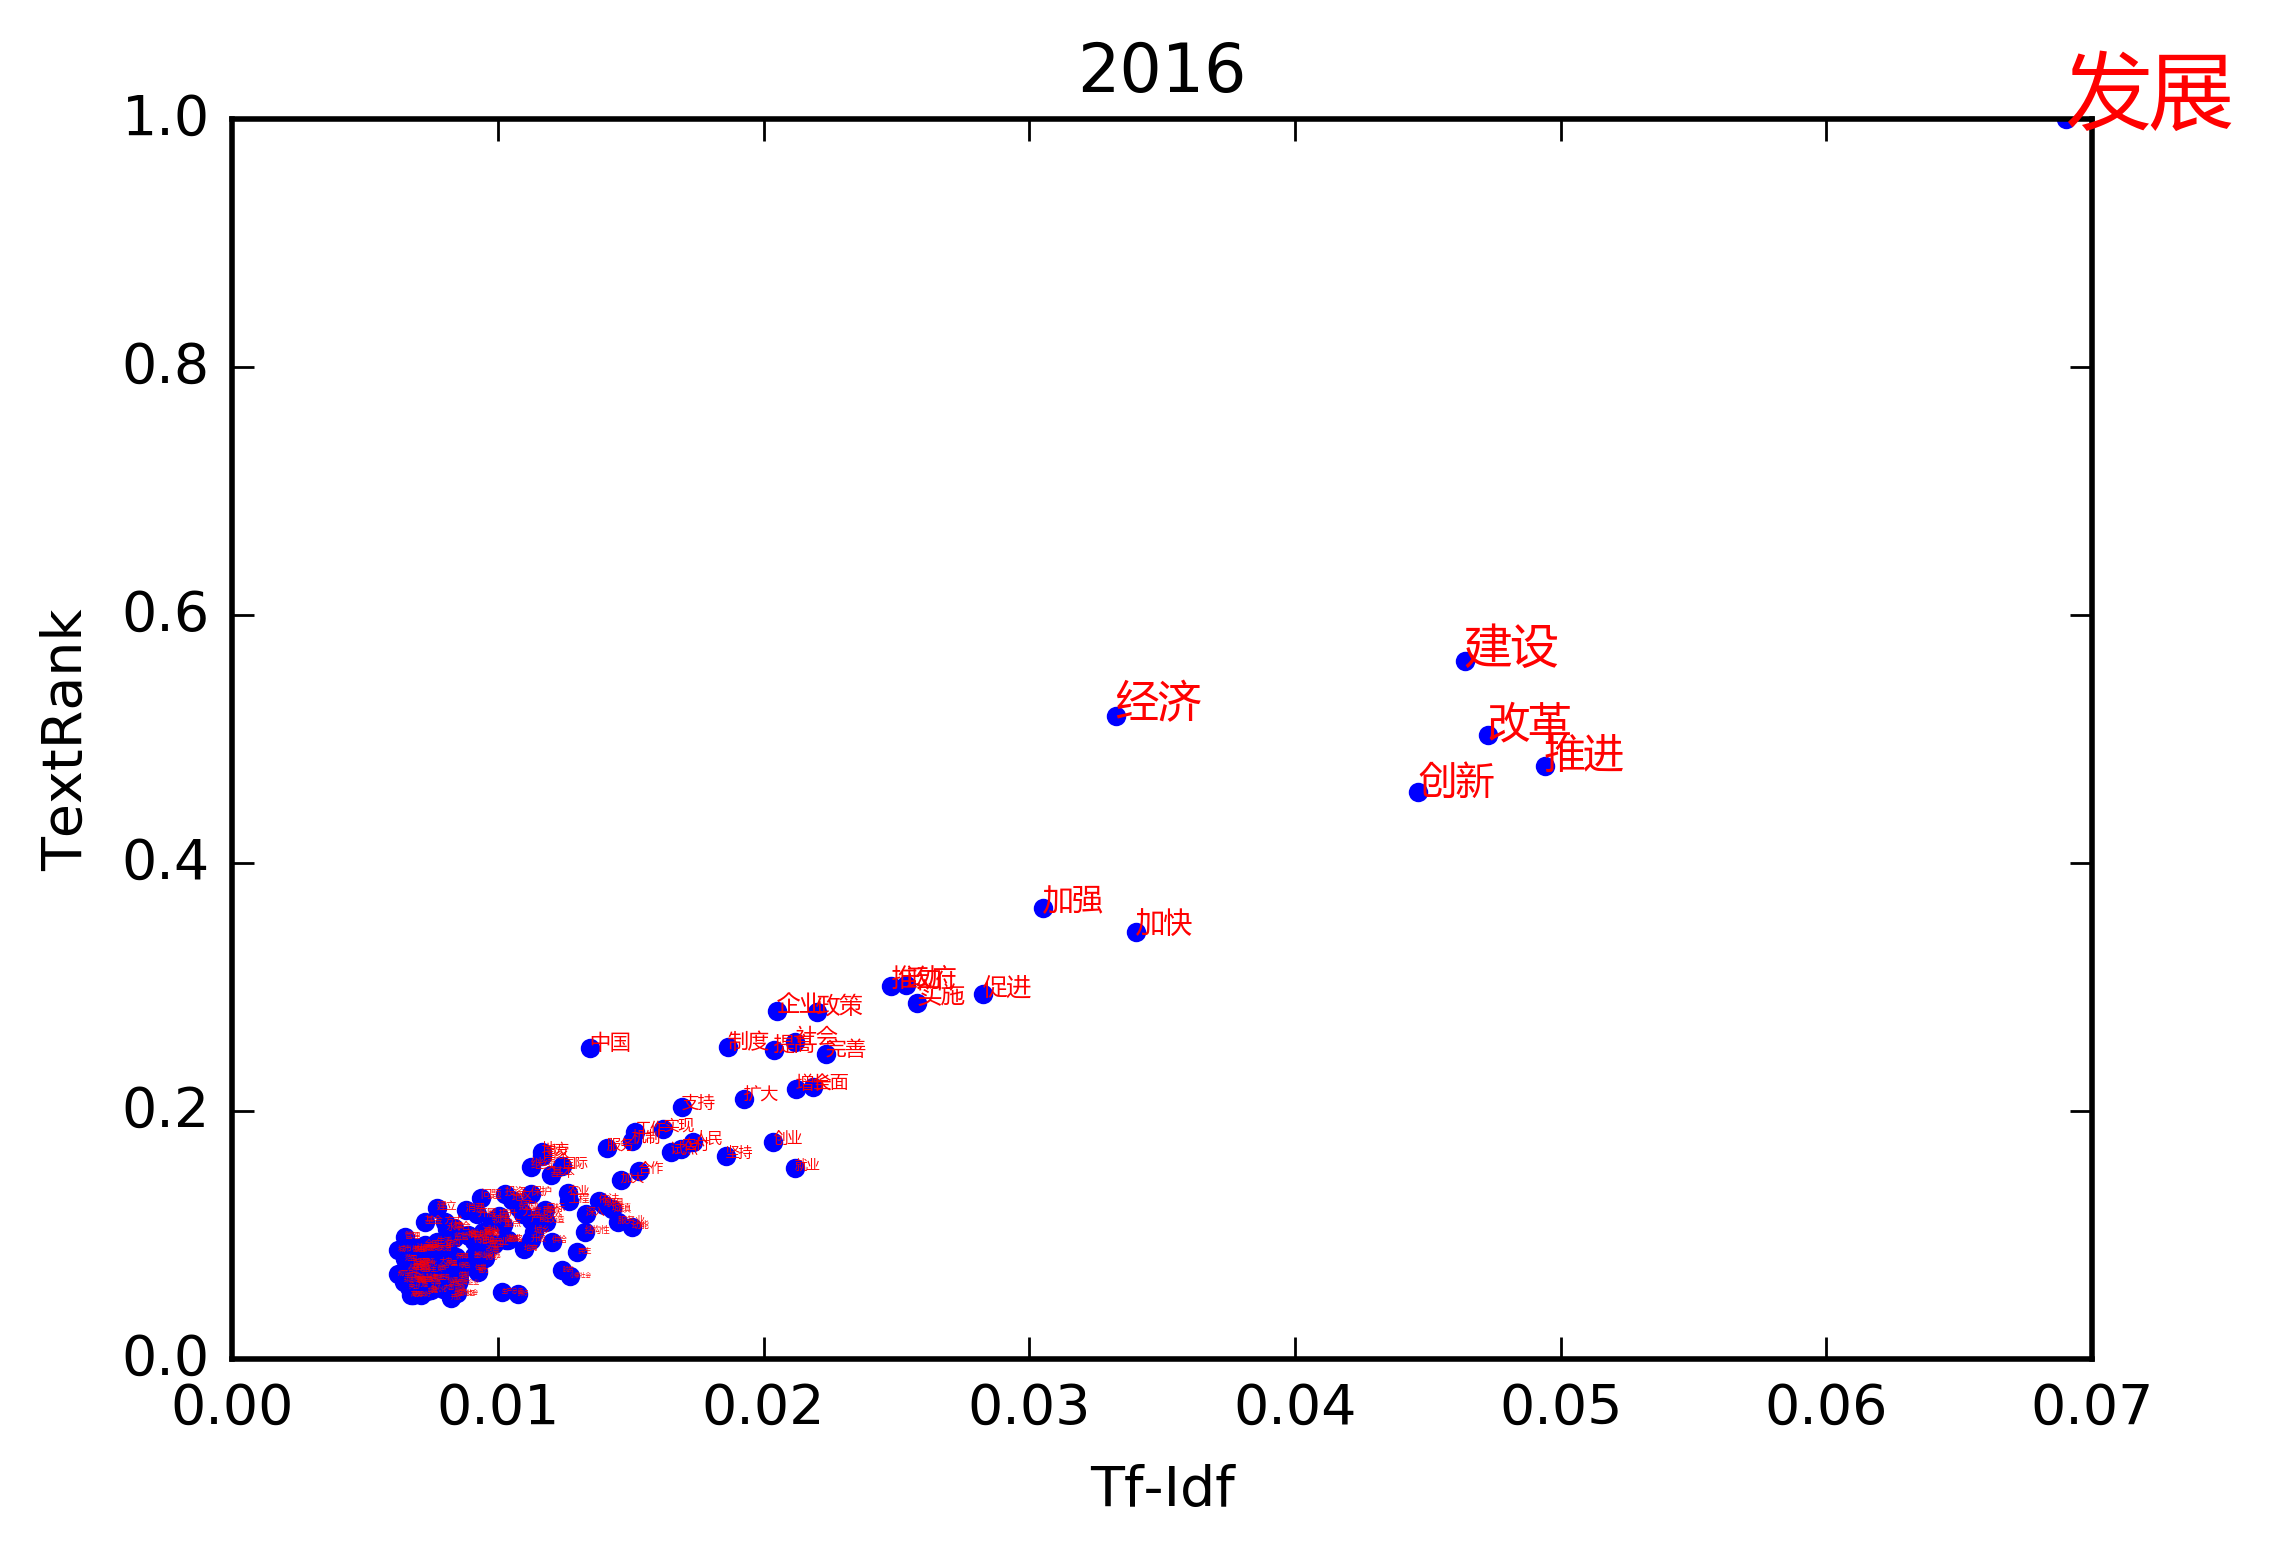

In [27]:
keywords(1)

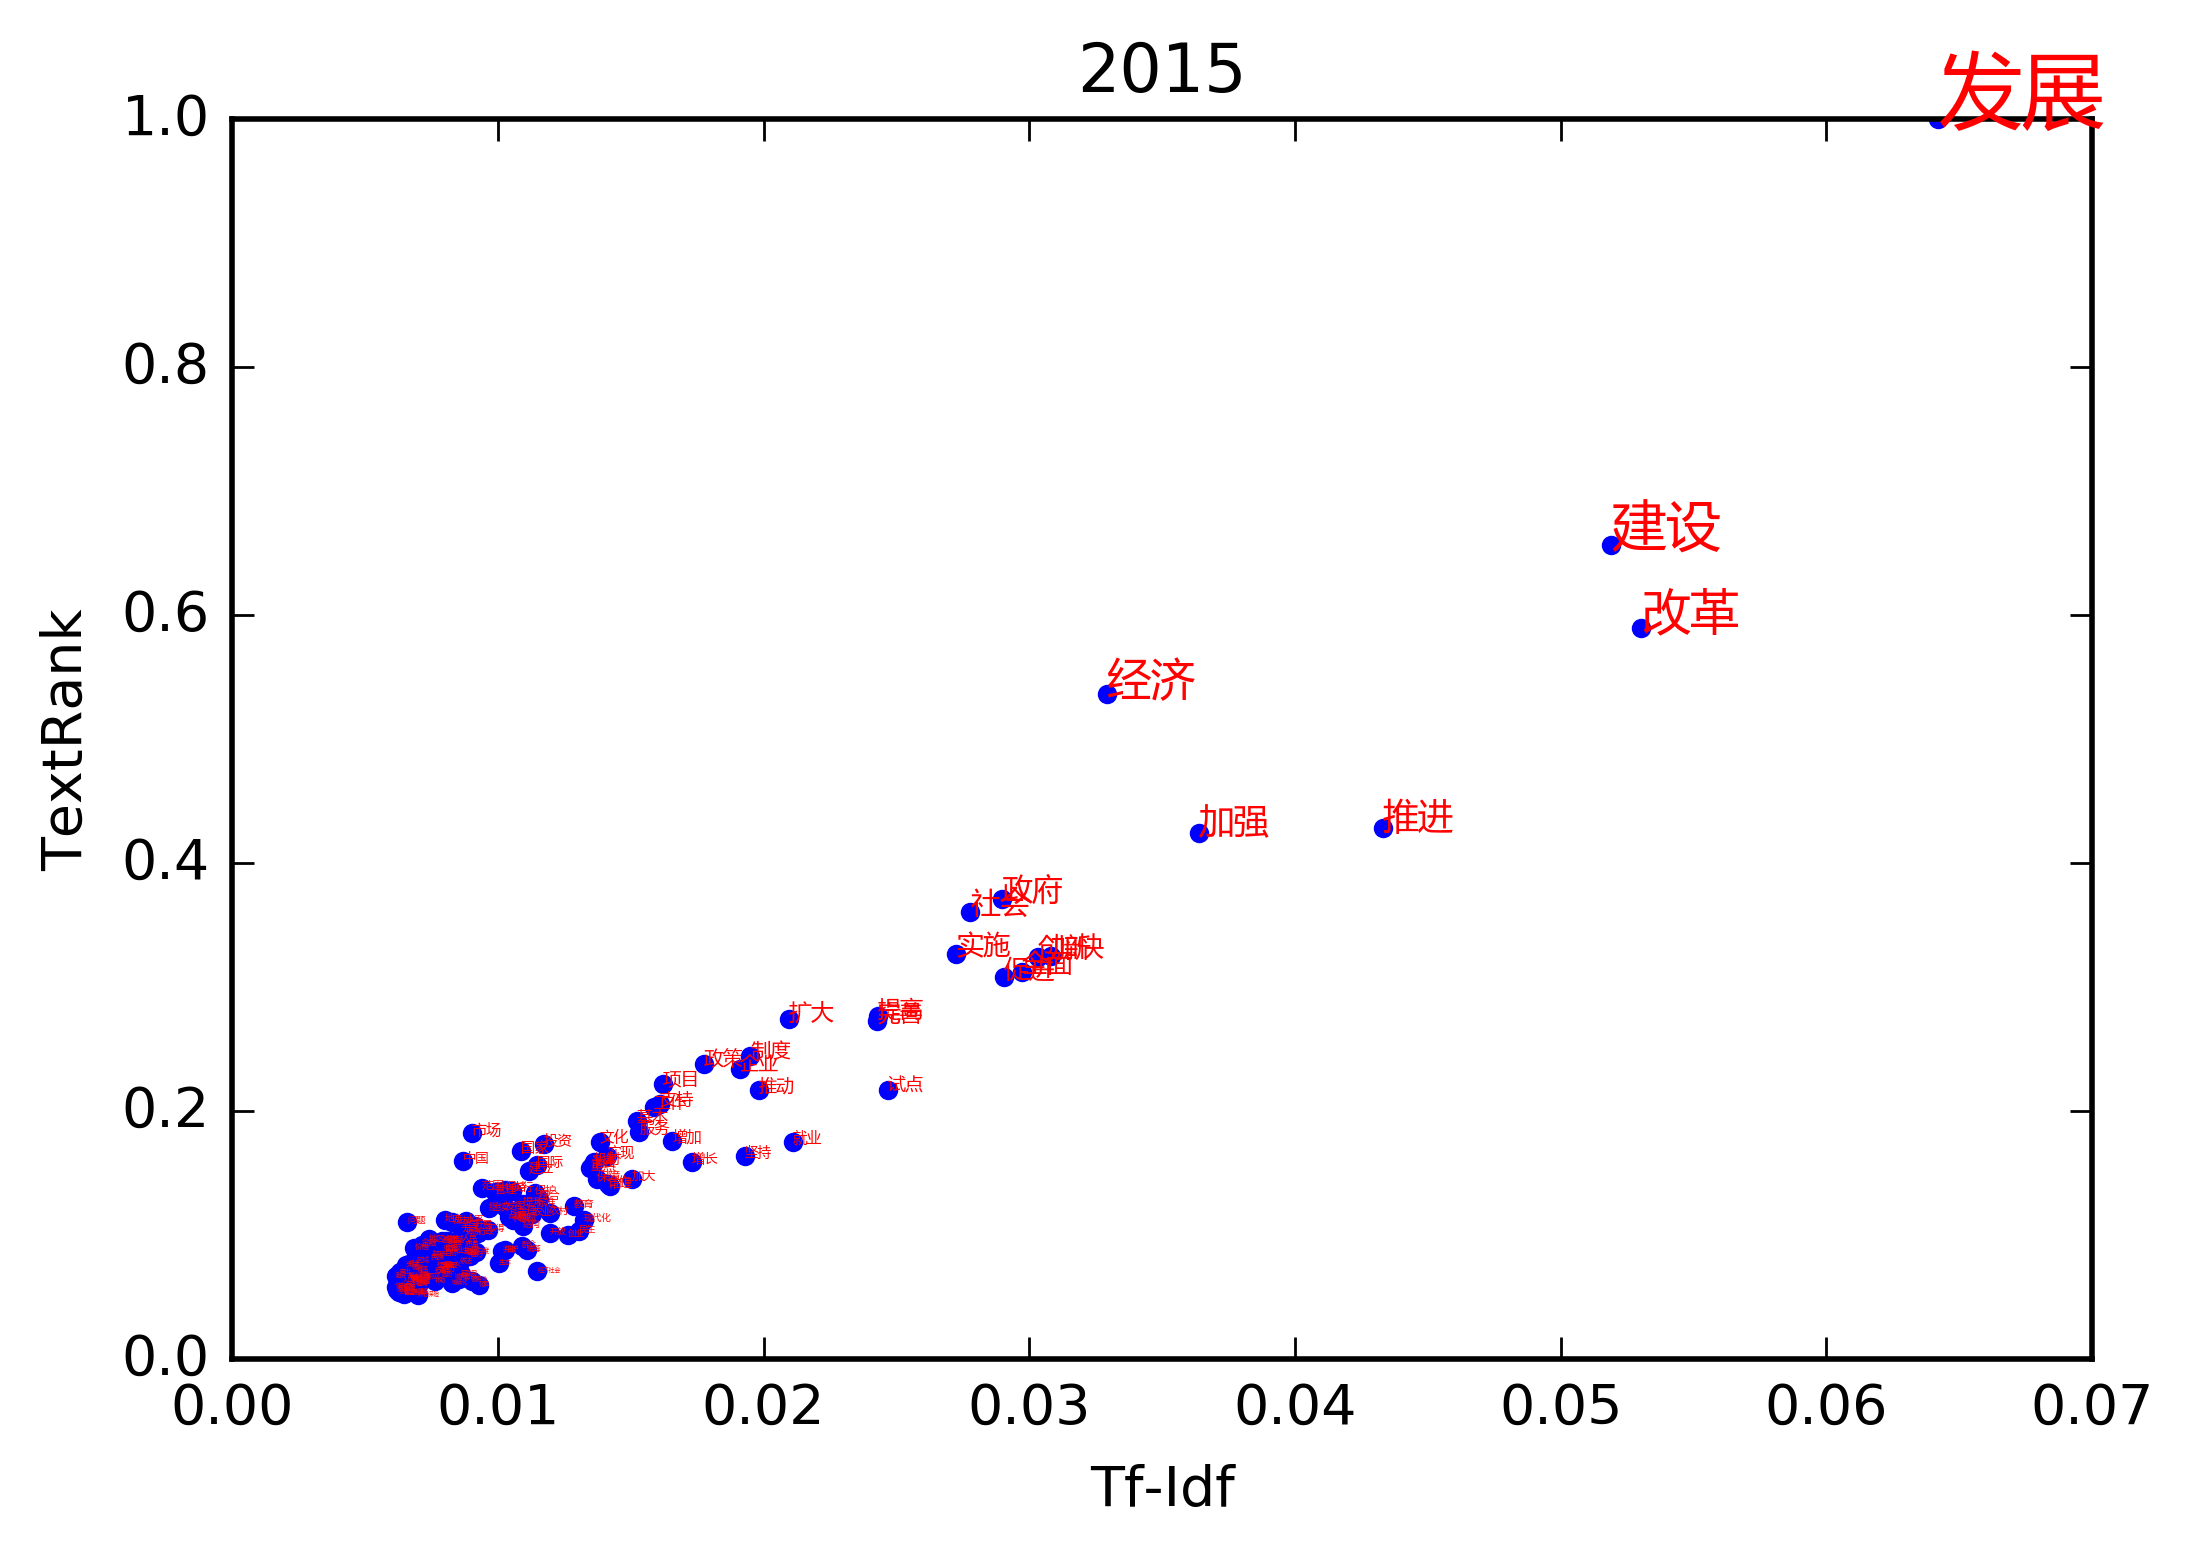

In [28]:
keywords(2)

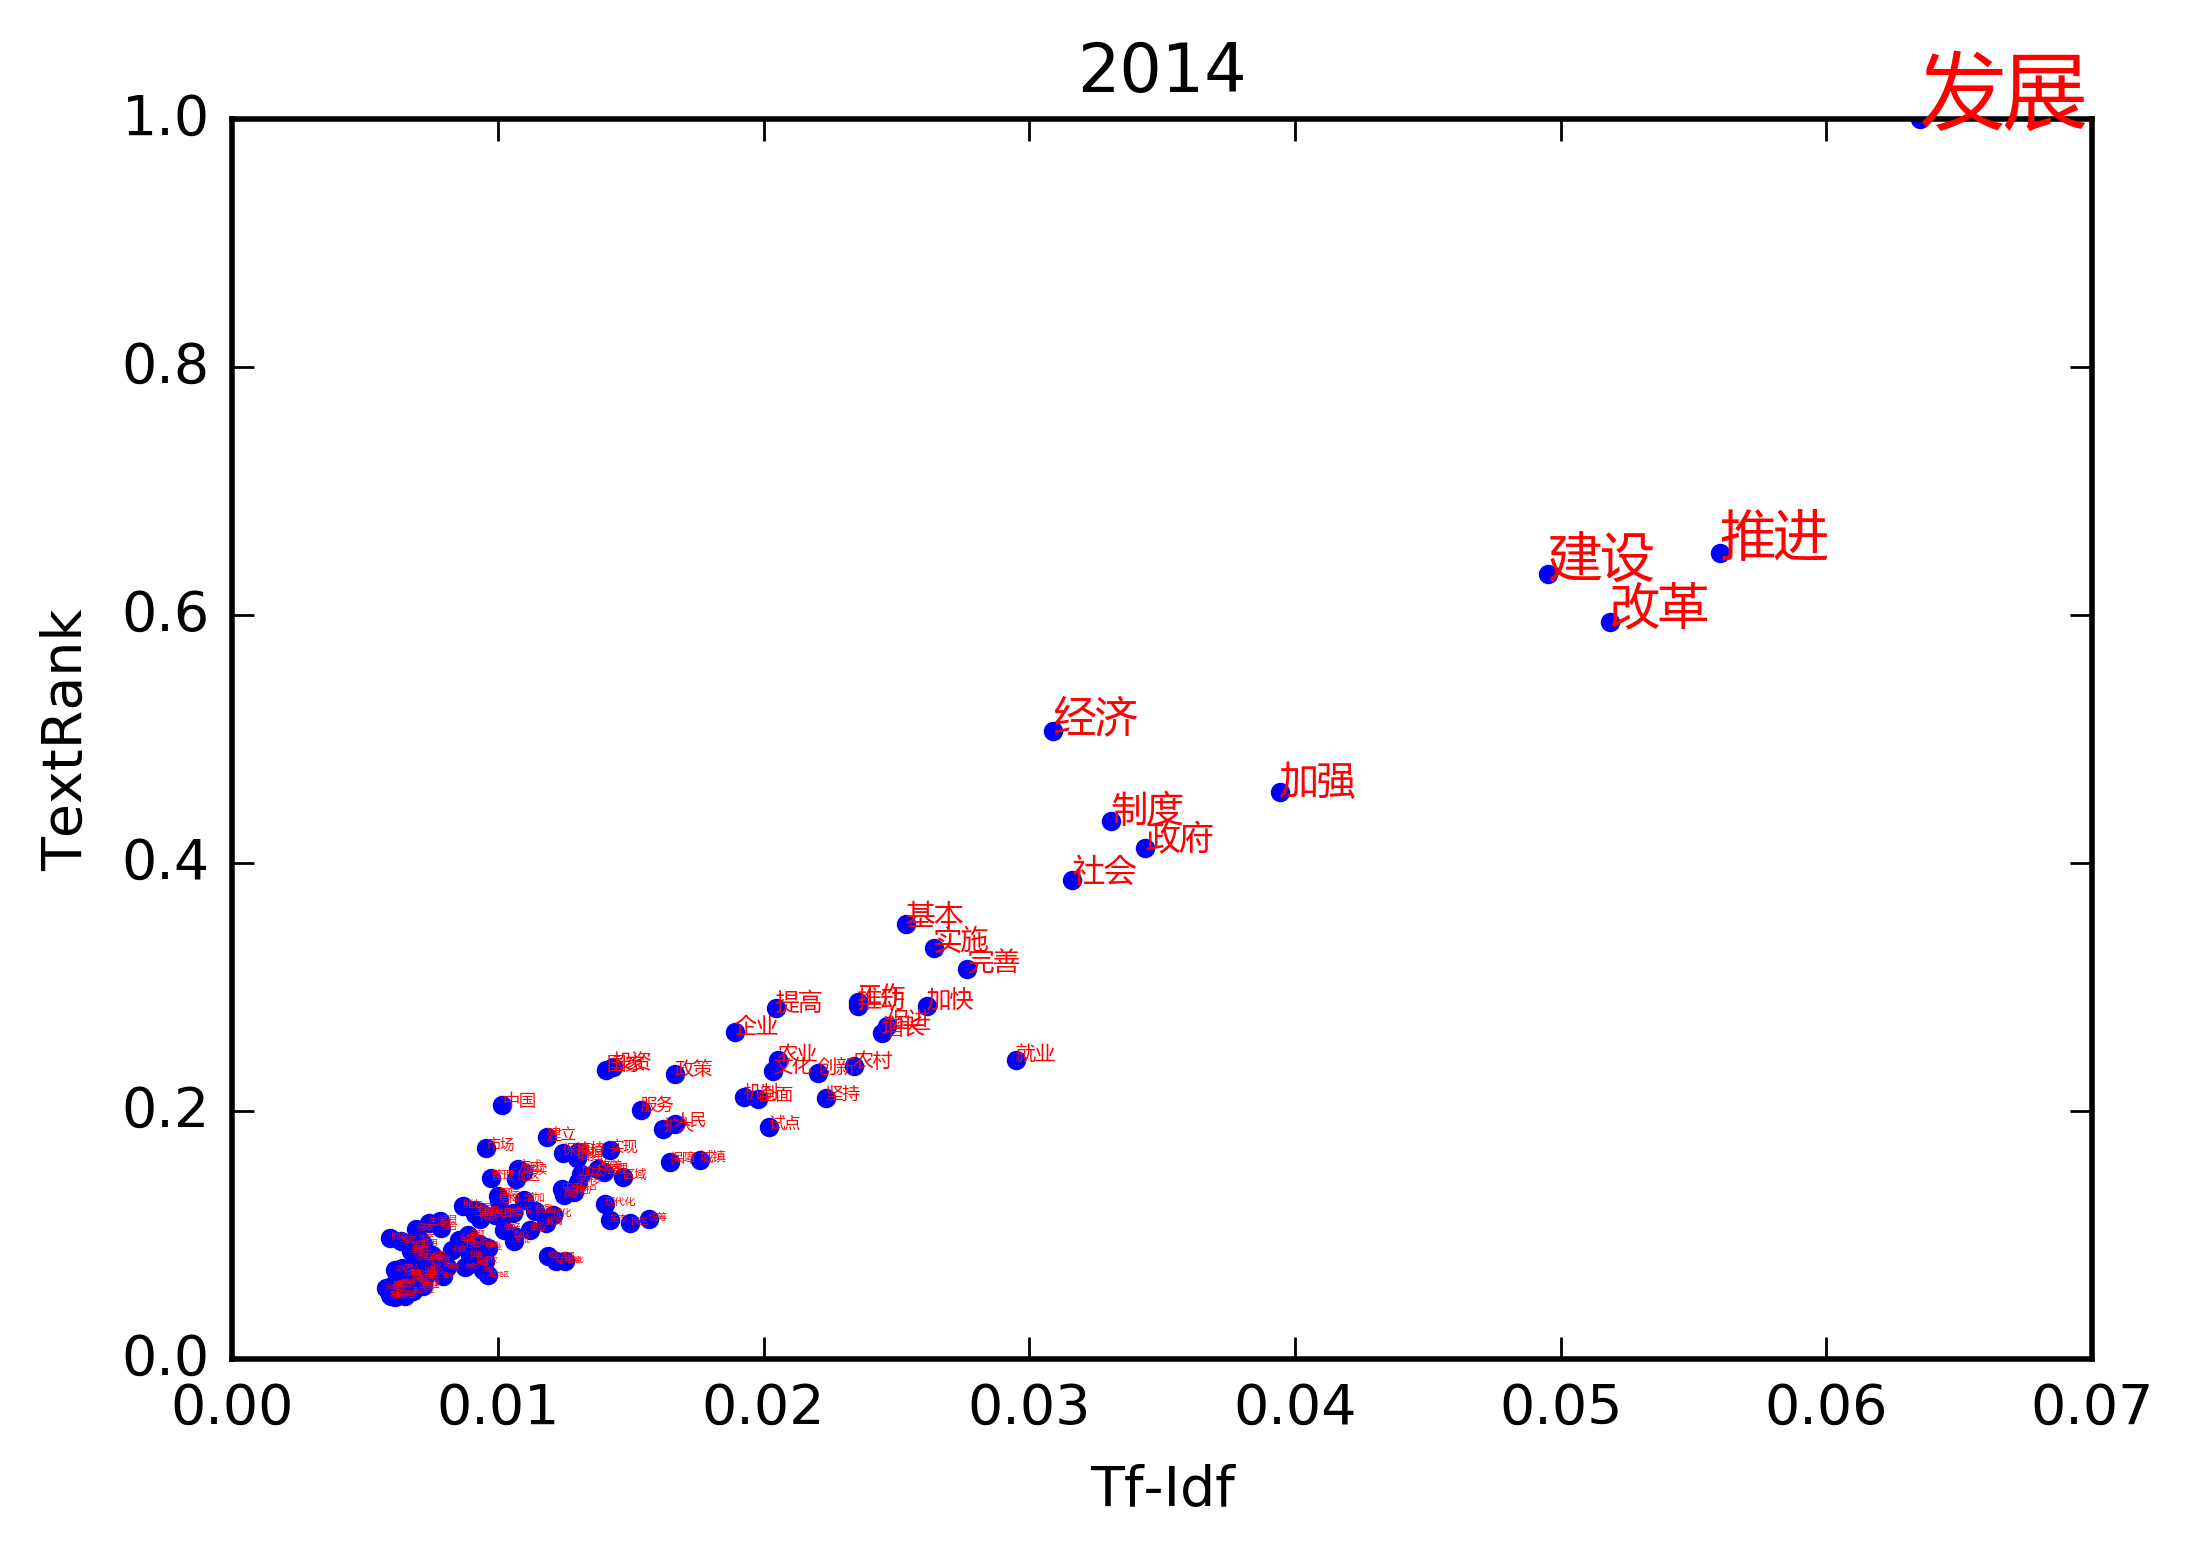

In [29]:
keywords(3)

## 4. 词云

In [30]:
def wordcloudplot(txt, year):
    wordcloud = WordCloud(font_path='C:/Windows/Fonts/msyh.ttc').generate(txt)
    # Open a plot of the generated image.
    plt.imshow(wordcloud)
    plt.title(year)
    plt.axis("off")
    #plt.show()

#### 基于tfidf过滤的词云

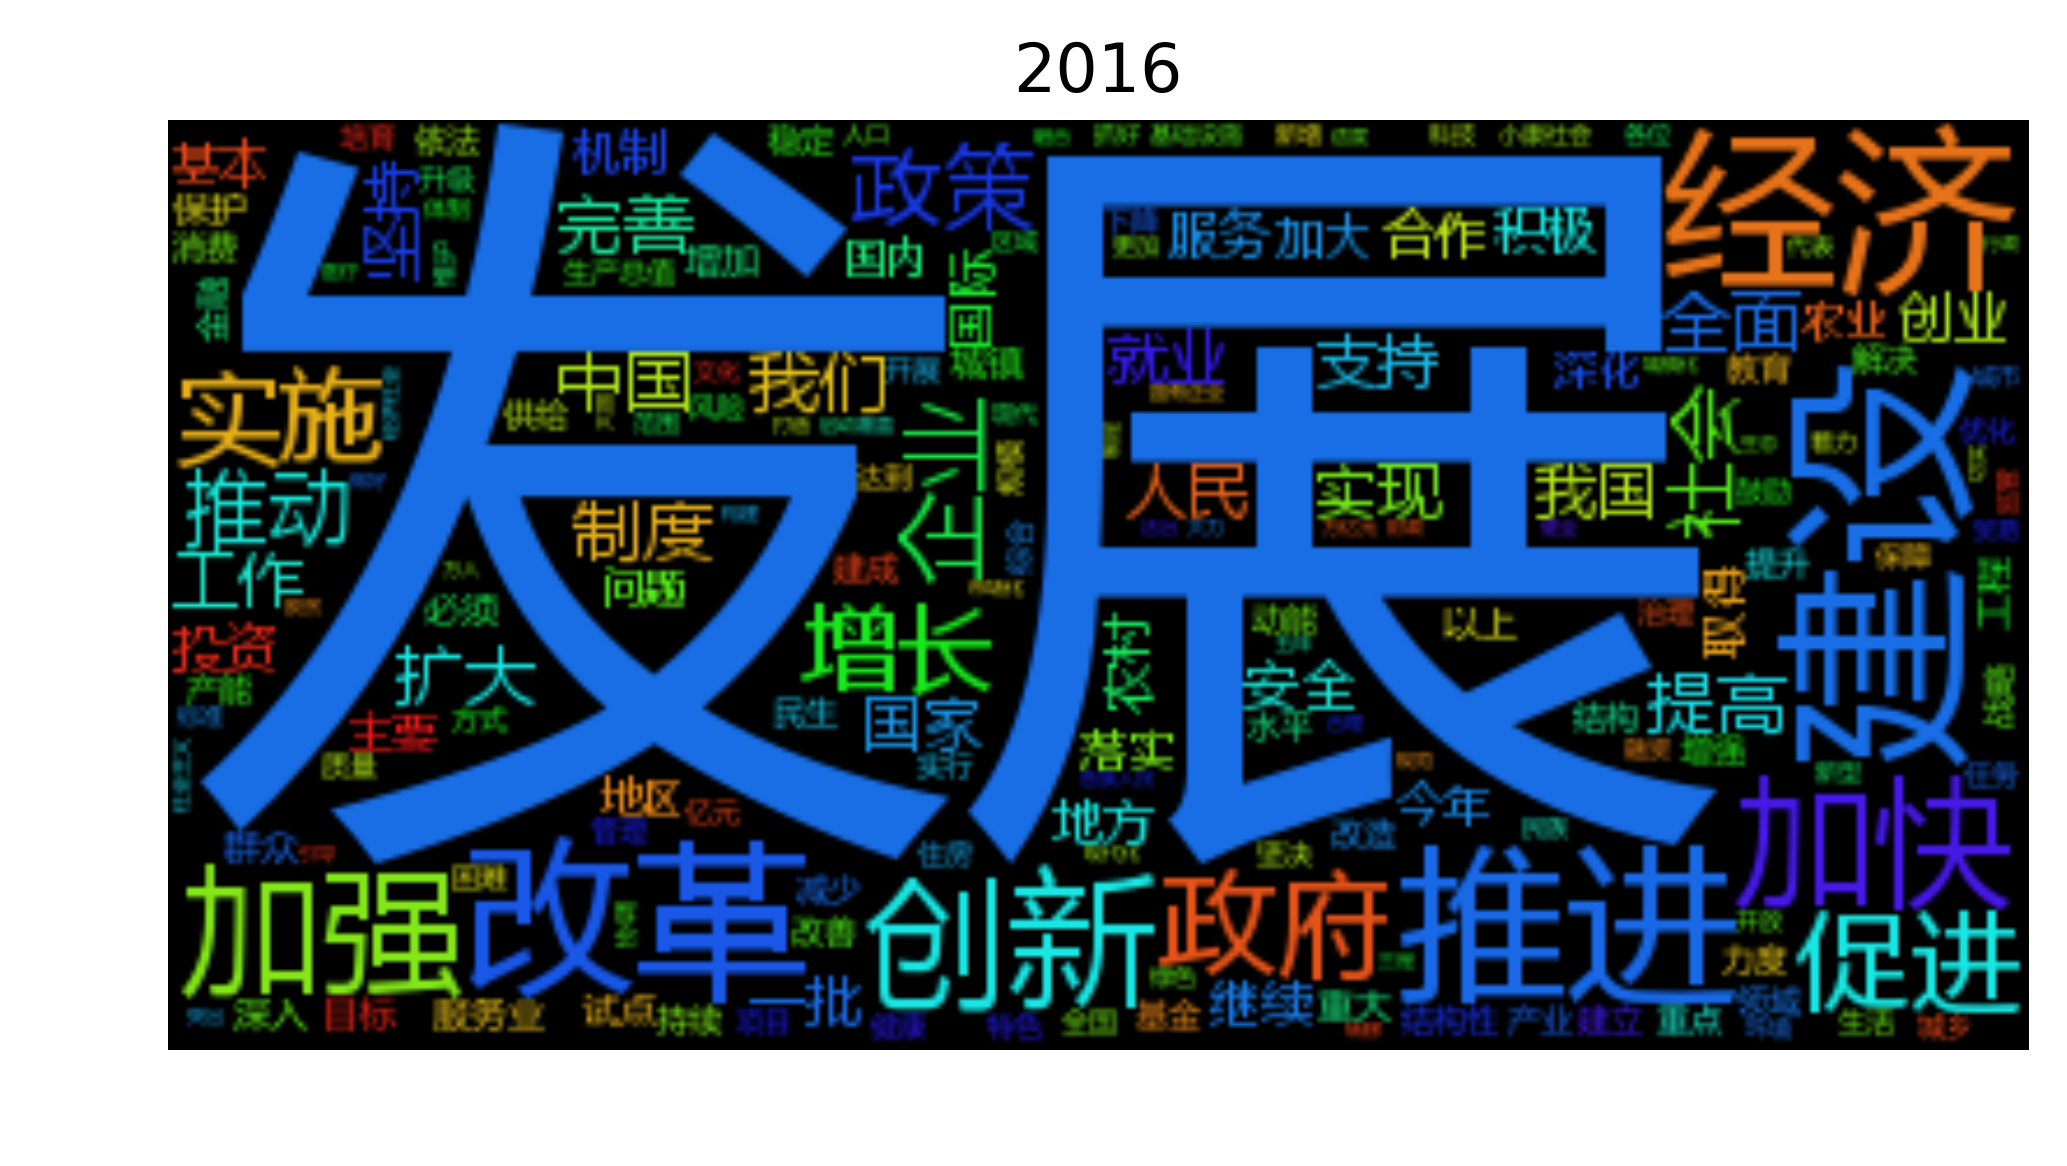

In [31]:
txt = reports[-1]
tfidf200= jieba.analyse.extract_tags(txt, topK=200, withWeight=False)
seg_list = jieba.cut(txt, cut_all=False)
seg_list = [i for i in seg_list if i in tfidf200]
txt200 = r' '.join(seg_list)
wordcloudplot(txt200, txt[:4]) 

In [32]:
wordfreq = defaultdict(int)
for i in seg_list:
    wordfreq[i] +=1
wordfreq = [[i, wordfreq[i]] for i in wordfreq]

wordfreq.sort(key= lambda x:x[1], reverse = True )
print u"、 ".join([ i[0] + u'（' + str(i[1]) +u'）' for i in wordfreq ])

发展（139）、 建设（68）、 经济（67）、 改革（62）、 推进（62）、 创新（56）、 加快（42）、 加强（41）、 政府（40）、 促进（37）、 实施（36）、 增长（36）、 企业（35）、 政策（35）、 推动（34）、 社会（34）、 中国（32）、 提高（31）、 我们（30）、 全面（28）、 完善（27）、 扩大（26）、 工作（26）、 制度（26）、 实现（25）、 就业（24）、 人民（24）、 支持（24）、 坚持（23）、 我国（22）、 国家（21）、 一批（21）、 创业（21）、 安全（21）、 农村（20）、 合作（20）、 国际（20）、 继续（19）、 地方（19）、 服务（19）、 投资（19）、 积极（19）、 取得（19）、 基本（18）、 落实（18）、 加大（18）、 机制（18）、 今年（18）、 地区（17）、 问题（17）、 农业（17）、 深化（17）、 主要（17）、 国内（16）、 工程（16）、 试点（16）、 目标（16）、 以上（16）、 城镇（15）、 保护（15）、 深入（15）、 重大（15）、 服务业（14）、 必须（14）、 增加（14）、 群众（14）、 动能（14）、 持续（14）、 依法（14）、 重点（14）、 产业（13）、 提升（13）、 改造（13）、 基金（13）、 金融（13）、 产能（13）、 供给（13）、 战略（13）、 稳定（13）、 力度（13）、 减少（13）、 领域（13）、 结构性（13）、 民生（13）、 结构（12）、 建成（12）、 教育（12）、 解决（12）、 增强（12）、 水平（12）、 消费（12）、 生活（12）、 升级（12）、 鼓励（12）、 方式（12）、 建立（12）、 改善（12）、 困难（11）、 全国（11）、 培育（11）、 开展（11）、 坚决（11）、 达到（11）、 城乡（11）、 综合（11）、 下降（10）、 生产总值（10）、 健康（10）、 特色（10）、 优化（10）、 住房（10）、 规模（10）、 风险（10）、 任务（10）、 管理（10）、 项目（10）、 质量（10）、 保障（10）、 更加（10）、 实行（10）、 亿元（10）、 新增（10）、 治理（10）、 代表（10）、 监管（

#### 基于停用词过滤的词云

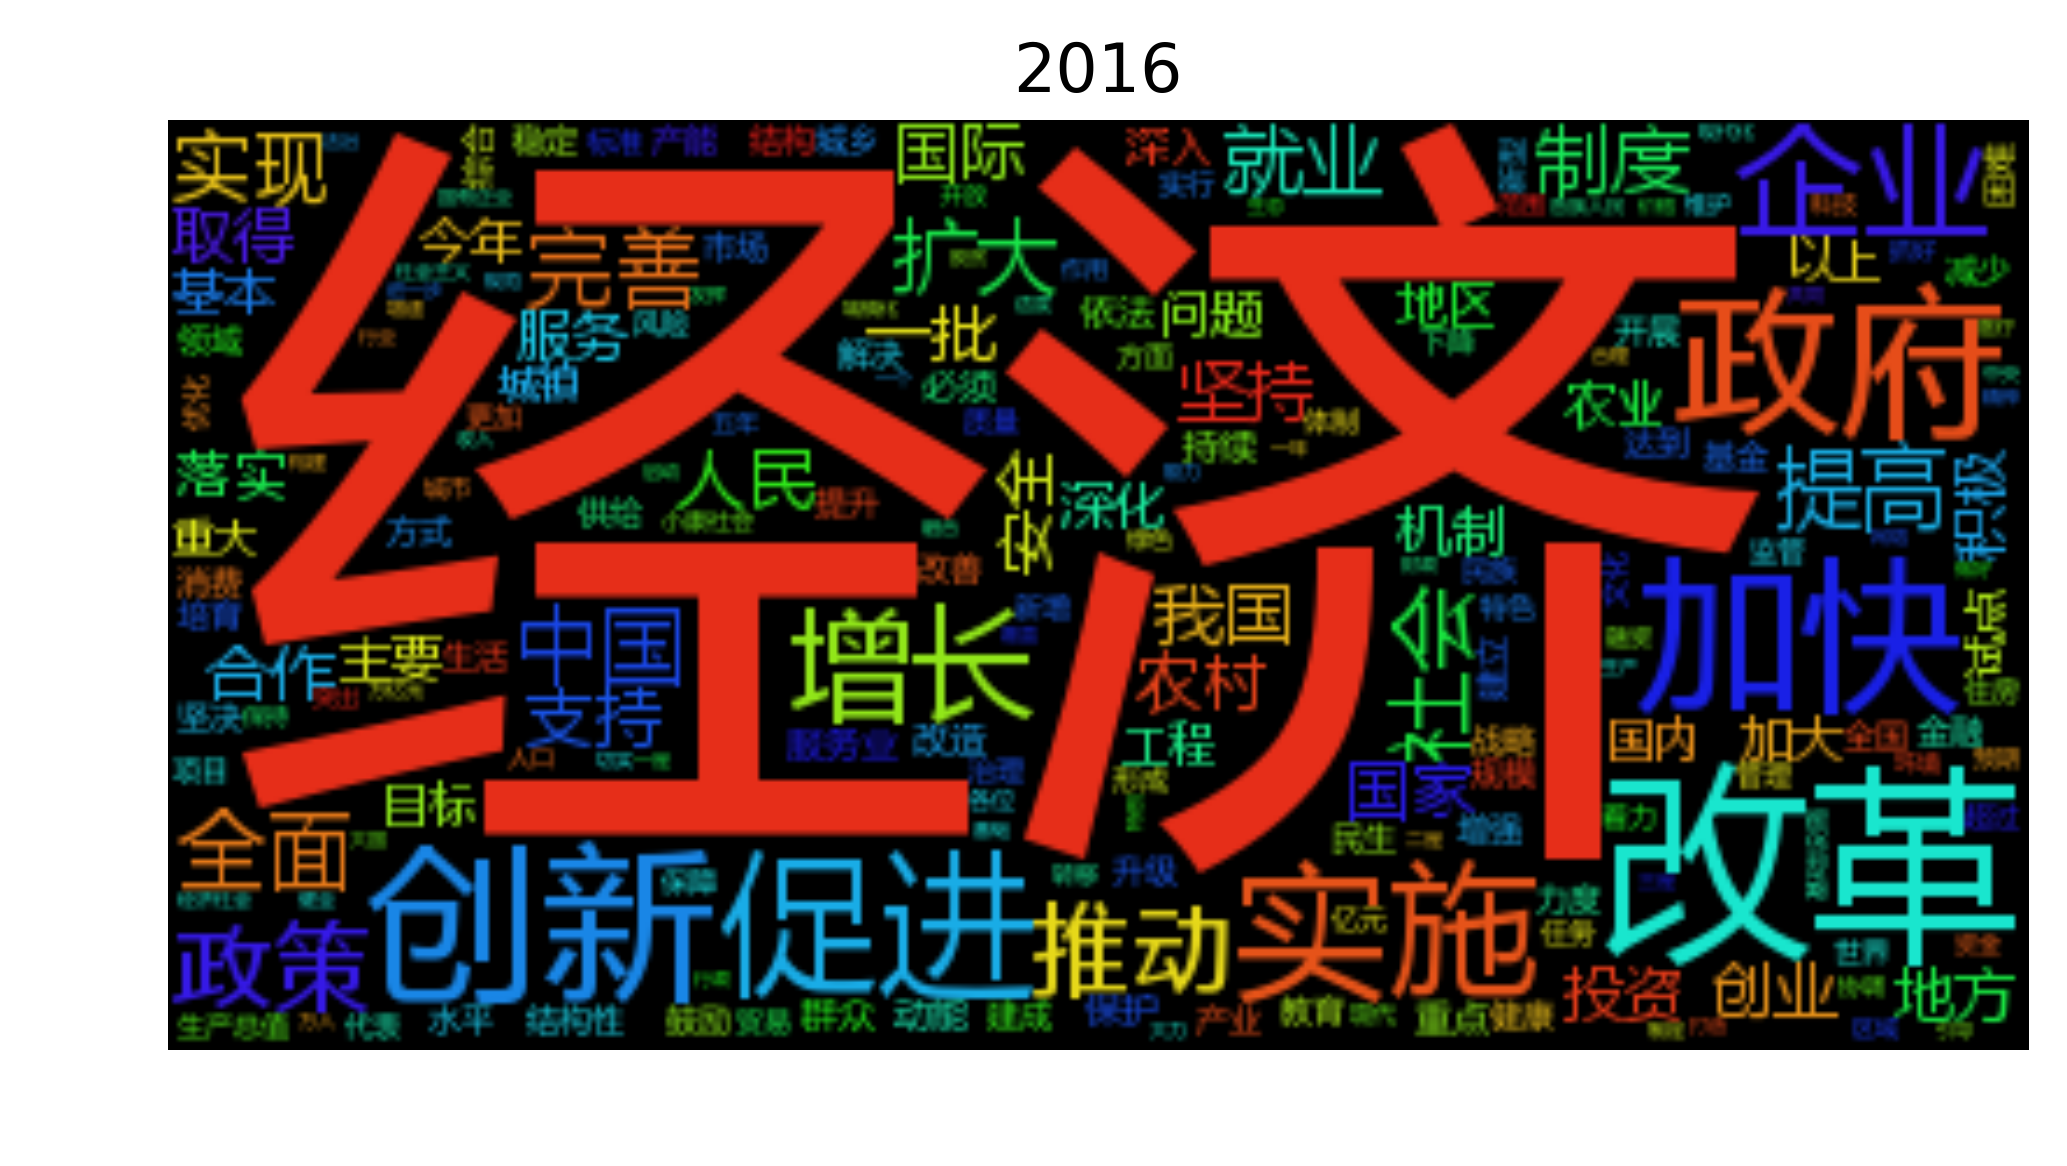

In [33]:
#jieba.add_word('股灾', freq=100, tag=None) 

txt = reports[-1]
seg_list = jieba.cut(txt, cut_all=False)
seg_list = [i for i in seg_list if i not in stopwords]
txt = r' '.join(seg_list)
wordcloudplot(txt, txt[:4]) 
#file_path = '/Users/chengjun/GitHub/cjc2016/figures/wordcloud-' + txt[:4] + '.png'
#plt.savefig(file_path,dpi = 300, bbox_inches="tight",transparent = True)

### 绘制1954-2016政府工作报告词云

In [ ]:
#jieba.add_word('股灾', freq=100, tag=None) 

for txt in reports:
    seg_list = jieba.cut(txt, cut_all=False)
    seg_list = [i for i in seg_list if i not in stopwords]
    txt = r' '.join(seg_list)
    wordcloudplot(txt, txt[:4]) 
    file_path = 'D:/program/cjc2016/figure/wordcloud-' + txt[:4] + '.png'
    plt.savefig(file_path,dpi = 400, bbox_inches="tight",transparent = True)